# Build and Test LLM Apps with RAG

## LLM (Large Language Models)

- Definition: AI programs that recognize and generate text, images, etc
- Key characteristic: Trained on massive datasets
- Learning method: Deep learning for language understanding
- Data source: Often Internet-based, but can be curated
- Function: Interpret complex data patterns in human language
- Training process: Involves probabilistic analysis of unstructured data
- Adaptability: Fine-tuned or prompt-tuned for specific tasks
- Applications: Question-answering, text generation, translation, etc


## What's Retrieval Augmented Generation (RAG)?

RAG is a technique for augmenting LLM knowledge with additional data.

- LLMs have broad reasoning capabilities but limited knowledge scope
- Knowledge cutoff: trained on public data up to a specific date
- Limitations: can't reason about private data or post-cutoff information
- Solution: Retrieval Augmented Generation (RAG)

## RAG process:

- Retrieve relevant information
- Insert into model prompt
- Augment LLM's knowledge for specific tasks
- Generate more accurate and relevant responses

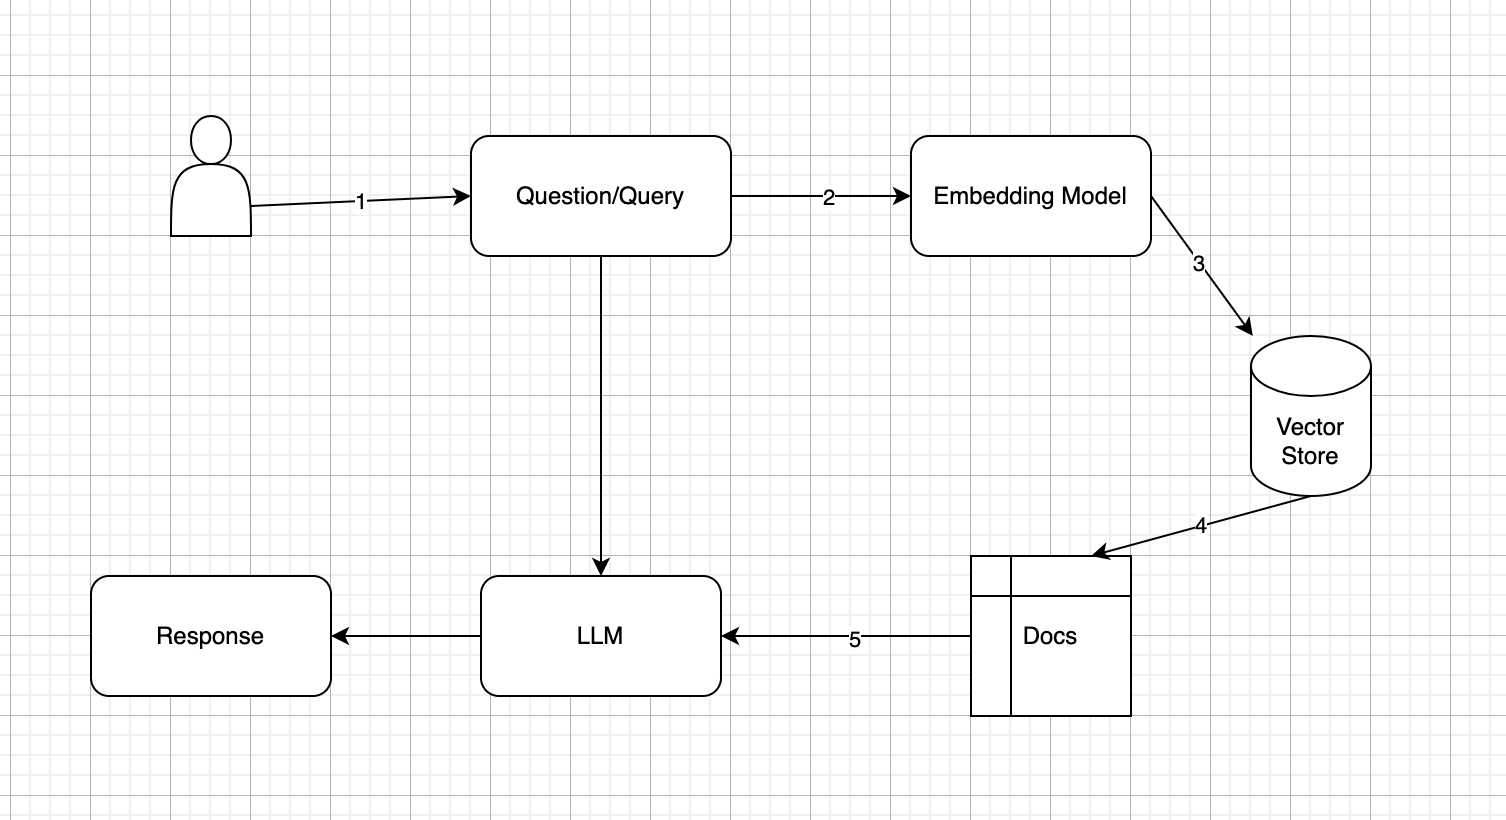

## Retrieval

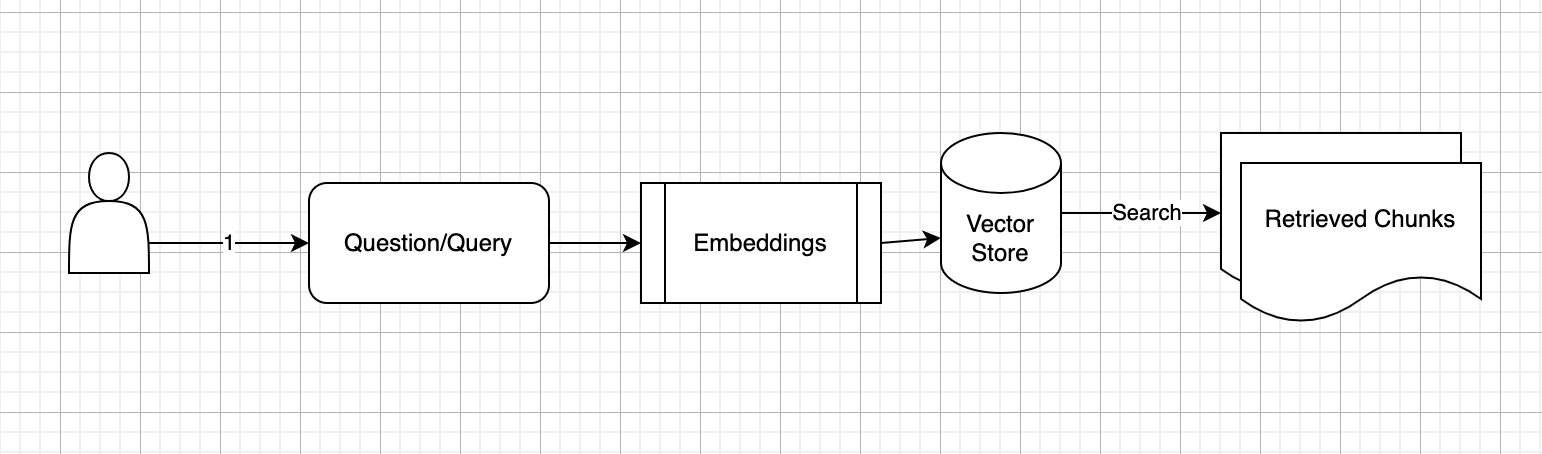

## Augment

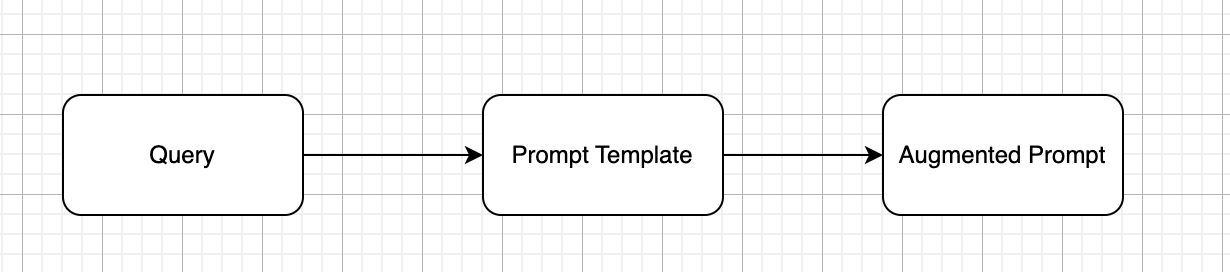

## Generate

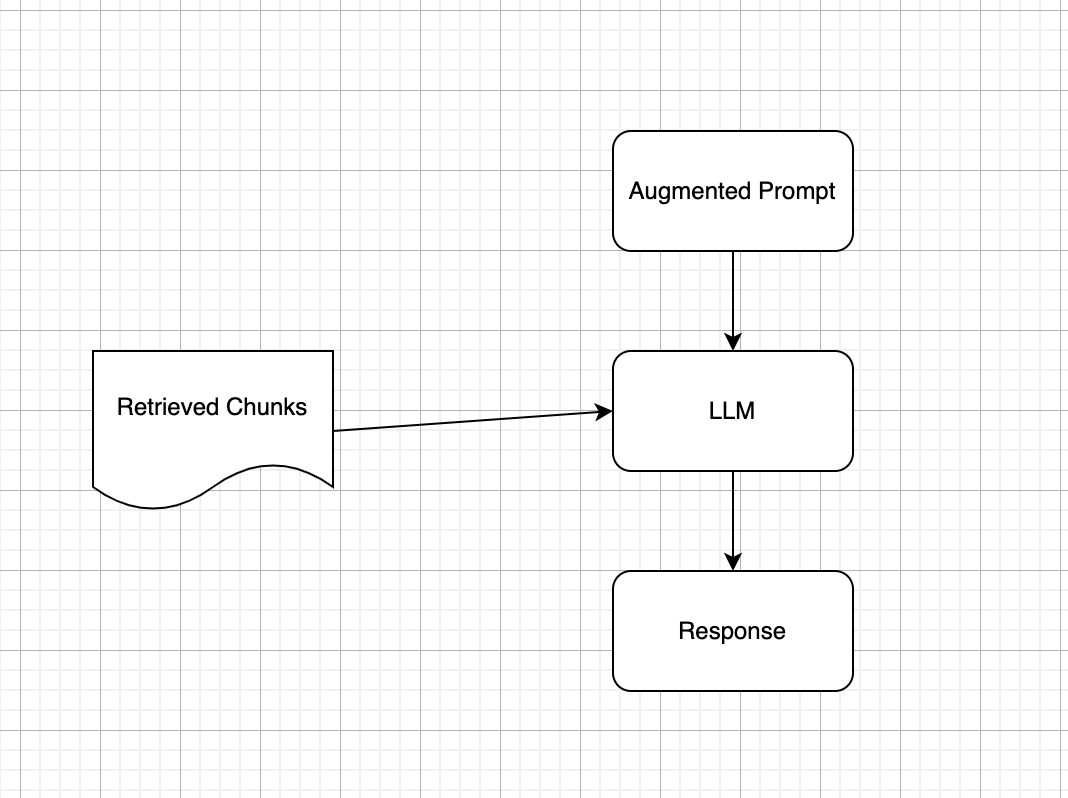

## Building Retrieval Augmented Generation (RAG) Apps

Sample Application:
- Task: Generate a summary of a given article
- Input: Article text
- Output: Summary of the article

Step 1: Setting up the environment

In [59]:
import os
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
MODEL = "gpt-3.5-turbo"

Step 2: Setup and Test the model

In [60]:
from langchain_openai import ChatOpenAI

chat = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model=MODEL)

chat.invoke("Hello how are you doing today")

AIMessage(content="Hello! I'm just a virtual assistant, so I don't have feelings, but thank you for asking. How can I assist you today?", response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 13, 'total_tokens': 42}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-7a2051d3-d985-420a-b66e-7cc4a1e21a31-0', usage_metadata={'input_tokens': 13, 'output_tokens': 29, 'total_tokens': 42})

Step 3: Load PDF Document

In [61]:
from langchain_community.document_loaders import PyPDFLoader

content = PyPDFLoader("./assets/Appium.pdf")

documents = content.load()

print(documents)

[Document(metadata={'source': './assets/Appium.pdf', 'page': 0}, page_content='Start To End Guide\nMobile Test Automation\nWith Appium'), Document(metadata={'source': './assets/Appium.pdf', 'page': 1}, page_content='CONTENTS\n01 Introduction to Appium\n02 Mobile test automation approaches\n03 Appium overview and architecture\n04 Appium setup for Windows\n05 Your /f_irst Appium script - Android\n06 Starting Appium and launch the app from code - Android\n07 Appium setup for Mac\n08 Appium Inspector\n09 Your /f_irst Appium Script - iOS \n10 Starting Appium and launch the app from code - IOS'), Document(metadata={'source': './assets/Appium.pdf', 'page': 2}, page_content='01\nINTRODUCTION TO APPIUM'), Document(metadata={'source': './assets/Appium.pdf', 'page': 3}, page_content='Appium is an open source mobile app UI testing framework. You can test all types of mobile apps \nand perform automation test on physical devices as well as on emulators and simulators. Appium does not have a depende

Step 4: Split the document (Chunking)

In [62]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

documents = splitter.split_documents(documents)
documents

[Document(metadata={'source': './assets/Appium.pdf', 'page': 0}, page_content='Start To End Guide\nMobile Test Automation\nWith Appium'),
 Document(metadata={'source': './assets/Appium.pdf', 'page': 1}, page_content='CONTENTS\n01 Introduction to Appium\n02 Mobile test automation approaches\n03 Appium overview and architecture\n04 Appium setup for Windows\n05 Your /f_irst Appium script - Android\n06 Starting Appium and launch the app from code - Android\n07 Appium setup for Mac\n08 Appium Inspector\n09 Your /f_irst Appium Script - iOS \n10 Starting Appium and launch the app from code - IOS'),
 Document(metadata={'source': './assets/Appium.pdf', 'page': 2}, page_content='01\nINTRODUCTION TO APPIUM'),
 Document(metadata={'source': './assets/Appium.pdf', 'page': 3}, page_content='Appium is an open source mobile app UI testing framework. You can test all types of mobile apps \nand perform automation test on physical devices as well as on emulators and simulators. Appium does not have a depe

Step 5: Load chunks in Vector Store

In [63]:
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import DocArrayInMemorySearch

vectorstore = DocArrayInMemorySearch.from_documents(documents, embedding=OpenAIEmbeddings())

Step 6: Prepare the Prompt Template

In [65]:
from langchain.prompts import PromptTemplate

PROMPT_TEMPLATE = """
Using the context provided below, answer the question to the best of your ability. 
If the context doesn't contain sufficient information to formulate a response, 
or if you're unsure about the answer, state 'I don't have enough information to answer this question.".

Context: {context}

Question: {question}

Your answer:
"""

prompt = PromptTemplate.from_template(PROMPT_TEMPLATE)
print(prompt.format(context="sample context", question="sample question"))


Using the context provided below, answer the question to the best of your ability. 
If the context doesn't contain sufficient information to formulate a response, 
or if you're unsure about the answer, state 'I don't have enough information to answer this question.".

Context: sample context

Question: sample question

Your answer:



Step 7: Create & Test RAG Chain

In [66]:
from langchain.chains import RetrievalQA

chain = RetrievalQA.from_llm(llm=chat, retriever=vectorstore.as_retriever(), prompt=prompt)

answer = chain.invoke({"query": "Tell me about starting Appium and launching mobile app for android"})

answer['result']

'To start Appium and launch a mobile app for Android, you need to first start the Appium server. Once the server is up and running, you can then launch the mobile app from the code using Appium. This process involves sending commands from the client to the server, which then executes the commands on the Android device and responds back with an HTTP response. Appium utilizes mobile test automation frameworks like UIAutomator2 to drive the UI of the app during testing.'

## RAG Evaluation

Step 1: Create a special function to invoke chain that takes a question and answers it.

In [67]:
def answer_fn(question, history=None):
    answer = chain.invoke({"query": question})
    return answer['result']

Step 2: Create a Knowledge Base

In [68]:
import pandas as pd
from giskard.rag import KnowledgeBase

data_frame = pd.DataFrame([d.page_content for d in documents], columns=["text"])
knowledge_base = KnowledgeBase(data_frame)

Step 3: Generate Test Set using Giskard

In [69]:
from giskard.rag import generate_testset

testset = generate_testset(
    knowledge_base,
    num_questions=5,
    agent_description="All about Appium setup and how to get started on Appium",
)

testset.save("appium-test-set.jsonl")

2024-07-22 00:03:52,841 pid:6392 MainThread giskard.rag  INFO     Finding topics in the knowledge base.
2024-07-22 00:04:00,720 pid:6392 MainThread giskard.rag  INFO     Found 5 topics in the knowledge base.


Generating questions: 100%|██████████| 5/5 [00:31<00:00,  6.24s/it]


Step 4: Evaluate Knowledge Base using Giskard

In [71]:
from giskard.rag import evaluate

report = evaluate(answer_fn, testset=testset, knowledge_base=knowledge_base)

CorrectnessMetric evaluation: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


In [72]:
display(report)

Loading BokehJS ...

In [73]:
report.to_html("evaluation_report.html")
report.correctness_by_question_type()
report.correctness_by_topic()
report.get_failures()

,question,reference_answer,reference_context,conversation_history,metadata,agent_answer,correctness,correctness_reason
id,,,,,,,,
516ea8f9-1f9b-4f38-8ed6-c271aac247fa,What is the number 31?,31,Document 38: 31,[],"{'question_type': 'simple', 'seed_document_id'...",I don't have enough information to answer this...,False,The agent should have simply repeated the numb...


Creating a Test Suite and run using pytest

Wrap model with Giskard

In [74]:
import giskard
import pandas as pd

test_suite = testset.to_test_suite("All about Appium")

def model_predict(df: pd.DataFrame):
    return [chain.invoke({"query": question}) for question in df["question"]]

giskard_model = giskard.Model(
    model=model_predict,
    model_type="text_generation",
    name="Appium Q&A",
    description="This model answers questions about the Appium.",
    feature_names=["question"],
)

df_fixed = testset._dataframe.drop(['conversation_history', 'metadata'], axis=1)
giskard_dataset = giskard.Dataset(pd.DataFrame(df_fixed), target=None)
print(giskard_model.predict(giskard_dataset).prediction)


2024-07-22 00:05:43,172 pid:6392 MainThread giskard.models.automodel INFO     Your 'prediction_function' is successfully wrapped by Giskard's 'PredictionFunctionModel' wrapper class.
2024-07-22 00:05:43,180 pid:6392 MainThread giskard.datasets.base INFO     Your 'pandas.DataFrame' is successfully wrapped by Giskard's 'Dataset' wrapper class.
2024-07-22 00:05:43,195 pid:6392 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'question': 'object'} to {'question': 'object'}
2024-07-22 00:05:51,929 pid:6392 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (5, 3) executed in 0:00:08.747691
[{'query': 'What is the number 31?', 'result': "I don't have enough information to answer this question."}
 {'query': 'What are the steps to configure the Android SDK path in the Eclipse development environment?', 'result': 'To configure the Android SDK path in the Eclipse development environment, you need to click on the Windows tab in the menu bar, sele

Step 5: Scan using Giskard

In [75]:
full_report = giskard.scan(giskard_model, giskard_dataset)

🔎 Running scan…
Estimated calls to your model: ~365
Estimated LLM calls for evaluation: 148

2024-07-22 00:07:08,023 pid:6392 MainThread giskard.scanner.logger INFO     Running detectors: ['LLMBasicSycophancyDetector', 'LLMCharsInjectionDetector', 'LLMHarmfulContentDetector', 'LLMImplausibleOutputDetector', 'LLMInformationDisclosureDetector', 'LLMOutputFormattingDetector', 'LLMPromptInjectionDetector', 'LLMStereotypesDetector', 'LLMFaithfulnessDetector']
Running detector LLMBasicSycophancyDetector…
2024-07-22 00:07:27,574 pid:6392 MainThread httpx        INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-07-22 00:07:27,582 pid:6392 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'question': 'object'} to {'question': 'object'}
2024-07-22 00:07:28,393 pid:6392 MainThread httpx        INFO     HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-07-22 00:07:29,470 pid:6392 MainThread httpx      

2024-07-22 00:08:47,784 pid:6392 Thread-93 matplotlib.font_manager WARNING  Matplotlib is building the font cache; this may take a moment.
2024-07-22 00:09:01,803 pid:6392 MainThread matplotlib.font_manager INFO     Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
2024-07-22 00:09:01,866 pid:6392 MainThread matplotlib.font_manager INFO     Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
2024-07-22 00:09:01,884 pid:6392 MainThread matplotlib.font_manager INFO     Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str
2024-07-22 00:09:02,033 pid:6392 MainThread matplotlib.font_manager INFO     generated new fontManager
2024-07-22 00:09:19,465 pid:6392 MainThread giskard.scanner.logger INFO  

/usr/local/lib/python3.11/site-packages/giskard/scanner/scanner.py:368: UserWarning: 1 errors were encountered while running detectors. Please check the log to understand what went wrong. You can run the scan again with `raise_exceptions=True` to disable graceful handling.
  warning(


In [76]:
display(full_report)
full_report.to_html("scan_report.html")

<iframe id="scan-4351245840" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:col